# Random Forest and CNN Optimization for ClimateWins

## Table of Contents

#### 1. Importing Libraries and Data
- Loading necessary libraries.
- Importing weather and pleasant weather prediction datasets.

#### 2. Data Wrangling
- Dropping irrelevant columns (e.g., wind speed, snow depth).
- Handling missing data by filling observations from nearby stations.

#### 3. Data Subsetting
- Filtering data for all weather stations from 2010–2019.
- Subsetting data for individual stations, such as `MAASTRICHT`.

#### 4. Preparing Data
- Aligning features and targets.
- Reshaping datasets for CNN compatibility.
- Splitting datasets into training and testing sets.

#### 5. Random Forest Model
- Training and evaluating a Random Forest model for all stations.
- Training a Random Forest model for `MAASTRICHT` data spanning all years.

#### 6. Hyperparameter Optimization - Random Forest
- Performing a grid search for hyperparameter optimization.
- Evaluating model performance before and after optimization.

#### 7. Feature Importance Analysis
- Identifying and visualizing key feature importances for all stations.
- Summarizing station-level importances.

#### 8. CNN Model for Deep Learning
- Reshaping data for CNN input.
- Configuring a baseline CNN model and evaluating its performance.

#### 9. Hyperparameter Optimization - CNN
- Running Bayesian optimization for hyperparameters.
- Evaluating optimized CNN performance and its impact on accuracy.

#### 10. Observations and Recommendations
- Comparing model performances before and after optimization.
- Recommending data segmentation strategies and prioritizing key weather variables (`temp_max` and `precipitation`) for Air Ambulance safety predictions.


# Part 1a: Random Forest — Hyperparameter Optimization - Random Forest 2010s
### Imports & Data Loading

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics  
from sklearn.tree import plot_tree

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Importing Answers-Weather_Prediction_Pleasant_Weather dataset
answers = pd.read_csv(r"C:\Users\isaac\Documents\CareerFoundry\3. Machine Learning with Python\Basics of ML for Analysis\04 Analysis\Data Sets\01 Raw Data\Answers-Weather_Prediction_Pleasant_Weather.csv")

# Importing Dataset-weather-prediction-dataset-processed dataset
weather = pd.read_csv(r"C:\Users\isaac\Documents\CareerFoundry\3. Machine Learning with Python\Basics of ML for Analysis\04 Analysis\Data Sets\01 Raw Data\Dataset-weather-prediction-dataset-processed.csv")

# Verifying imports
answers.head(), weather.head()

(       DATE  BASEL_pleasant_weather  BELGRADE_pleasant_weather  \
 0  19600101                       0                          0   
 1  19600102                       0                          0   
 2  19600103                       0                          0   
 3  19600104                       0                          0   
 4  19600105                       0                          0   
 
    BUDAPEST_pleasant_weather  DEBILT_pleasant_weather  \
 0                          0                        0   
 1                          0                        0   
 2                          0                        0   
 3                          0                        0   
 4                          0                        0   
 
    DUSSELDORF_pleasant_weather  HEATHROW_pleasant_weather  \
 0                            0                          0   
 1                            0                          0   
 2                            0                          0  

## Data Wrangling

In [5]:
weather = weather.drop([
    # Gdansk
    'GDANSK_cloud_cover', 'GDANSK_humidity', 'GDANSK_precipitation',
    'GDANSK_snow_depth', 'GDANSK_temp_mean', 'GDANSK_temp_min', 'GDANSK_temp_max',
    
    # Rome
    'ROMA_cloud_cover', 'ROMA_wind_speed', 'ROMA_humidity', 'ROMA_pressure',
    'ROMA_sunshine', 'ROMA_temp_mean',
    
    # Tours
    'TOURS_wind_speed', 'TOURS_humidity', 'TOURS_pressure', 'TOURS_global_radiation',
    'TOURS_precipitation', 'TOURS_temp_mean', 'TOURS_temp_min', 'TOURS_temp_max'
], axis=1)
weather.shape

(22950, 149)

### Removing Observation Types Missing in Most Stations

Two observation types are problematic:

- wind_speed (only 9 stations had data)
- now_depth (only 6 stations had data)

Since they are missing for most other stations, drop any columns that end with _wind_speed or _snow_depth:

In [7]:
# Identify columns to drop
columns_to_drop = weather.filter(regex='(_wind_speed|_snow_depth)$').columns
print(columns_to_drop)  # Just to verify

# Drop those columns
weather = weather.drop(columns=columns_to_drop)

Index(['BASEL_wind_speed', 'BASEL_snow_depth', 'DEBILT_wind_speed',
       'DUSSELDORF_wind_speed', 'DUSSELDORF_snow_depth', 'HEATHROW_snow_depth',
       'KASSEL_wind_speed', 'LJUBLJANA_wind_speed', 'MAASTRICHT_wind_speed',
       'MADRID_wind_speed', 'MUNCHENB_snow_depth', 'OSLO_wind_speed',
       'OSLO_snow_depth', 'SONNBLICK_wind_speed', 'VALENTIA_snow_depth'],
      dtype='object')


### Fill 3 Individual Observations from Nearby Stations

Three specific columns were missing:
- KASSEL_cloud_cover (we copied from DUSSELDORF_cloud_cover)
- STOCKHOLM_humidity (we copied from OSLO_humidity)
- MUNCHENB_pressure (we copied from BASEL_pressure)

In [9]:
# locating columns (to figure out where to insert)
weather.columns.get_loc('HEATHROW_temp_max')  
# returns an index so we know where to insert Kassel’s data

# Insert new columns (copying from nearest station)
weather.insert(56, 'KASSEL_cloud_cover', weather['DUSSELDORF_cloud_cover'])
weather.insert(119, 'STOCKHOLM_humidity', weather['OSLO_humidity'])
weather.insert(94, 'MUNCHENB_pressure', weather['BASEL_pressure'])

weather.columns
# Verify they are inserted as expected.

Index(['DATE', 'MONTH', 'BASEL_cloud_cover', 'BASEL_humidity',
       'BASEL_pressure', 'BASEL_global_radiation', 'BASEL_precipitation',
       'BASEL_sunshine', 'BASEL_temp_mean', 'BASEL_temp_min',
       ...
       'STOCKHOLM_temp_max', 'VALENTIA_cloud_cover', 'VALENTIA_humidity',
       'VALENTIA_pressure', 'VALENTIA_global_radiation',
       'VALENTIA_precipitation', 'VALENTIA_sunshine', 'VALENTIA_temp_mean',
       'VALENTIA_temp_min', 'VALENTIA_temp_max'],
      dtype='object', length=137)

## Subset to One Decade

In [11]:
#  Subset by decade (2010–2019)

# DATE column is interpretable as a string or an integer for slicing
# For example, if DATE is an integer like 20100101 -> str[:4] = '2010'
weather['DATE'] = weather['DATE'].astype(str)
answers['DATE'] = answers['DATE'].astype(str)

dfdecade_weather = weather[
    (weather['DATE'].str[:4] >= '2010') & (weather['DATE'].str[:4] <= '2019')
].copy()

dfdecade_answers = answers[
    (answers['DATE'].str[:4] >= '2010') & (answers['DATE'].str[:4] <= '2019')
].copy()

print("Subset weather:", dfdecade_weather.shape)
print("Subset answers:", dfdecade_answers.shape)

Subset weather: (3652, 137)
Subset answers: (3652, 16)


## Data Wrangling and Shape Checks on Subset

In [13]:
# Drop columns you don’t need (DATE, MONTH, etc.)
# ---------------------------------------------------------------------
dfdecade_weather.drop(columns=['DATE', 'MONTH'], errors='ignore', inplace=True)

print("Weather shape after dropping unneeded columns:", dfdecade_weather.shape)

# ---------------------------------------------------------------------
# Align answers by dropping DATE 
# ---------------------------------------------------------------------
dfdecade_answers.drop(columns=['DATE'], errors='ignore', inplace=True)

print("Answers shape after dropping unneeded columns:", dfdecade_answers.shape)

#  Final shape checks

print(dfdecade_weather.head(2))
print(dfdecade_answers.head(2))

Weather shape after dropping unneeded columns: (3652, 135)
Answers shape after dropping unneeded columns: (3652, 15)
       BASEL_cloud_cover  BASEL_humidity  BASEL_pressure  \
18263                  8            0.93          0.9965   
18264                  3            0.74          1.0193   

       BASEL_global_radiation  BASEL_precipitation  BASEL_sunshine  \
18263                    0.18                 0.56             0.0   
18264                    0.58                 0.00             5.2   

       BASEL_temp_mean  BASEL_temp_min  BASEL_temp_max  BELGRADE_cloud_cover  \
18263              2.9            -0.2             4.8                     6   
18264             -1.5            -4.2             0.4                     8   

       ...  STOCKHOLM_temp_max  VALENTIA_cloud_cover  VALENTIA_humidity  \
18263  ...                -7.0                     1               0.80   
18264  ...                -7.1                     1               0.82   

       VALENTIA_pressure

In [14]:
print("Subset weather:", dfdecade_weather.shape)
print("Subset answers:", dfdecade_answers.shape)

Subset weather: (3652, 135)
Subset answers: (3652, 15)


---

## All Stations for a Single Decade
Target `y` has shape (3652, 15) — i.e., 15 columns of 0/1 for each station’s “pleasant” or “unpleasant” weather.

Set up `X` and `y`:

In [17]:
X = dfdecade_weather.to_numpy()   # (3652, 135)
y = dfdecade_answers.to_numpy()   # (3652, 15)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (3652, 135)
y shape: (3652, 15)


### Train/Test Split:

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
print("Train X:", X_train.shape, "Train y:", y_train.shape)
print("Test X:", X_test.shape, "Test y:", y_test.shape)

Train X: (2739, 135) Train y: (2739, 15)
Test X: (913, 135) Test y: (913, 15)


### Train RandomForest in multi-output classification mode.

- In scikit-learn, if `y_train` is 2D (shape `(n_samples, n_outputs)`), `RandomForestClassifier` can still fit it as a multi-output classification problem.

In [21]:
from sklearn.ensemble import RandomForestClassifier
rf_all = RandomForestClassifier(n_estimators=100, random_state=42)
rf_all.fit(X_train, y_train)

y_pred = rf_all.predict(X_test)

# Evaluate
from sklearn.metrics import accuracy_score
multi_output_acc = accuracy_score(y_test, y_pred)
print("All-Stations (multi-output) RF Accuracy:", multi_output_acc)

All-Stations (multi-output) RF Accuracy: 0.5914567360350493


---

## Hyperparameter Search


In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'max_features': [3, 5, 10],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 5],
    # 'criterion': ['gini', 'entropy']  # optional
}

rf_for_search = RandomForestClassifier(random_state=42)

grid = GridSearchCV(
    estimator=rf_for_search,
    param_grid=param_grid,
    scoring='accuracy',      # or 'f1_weighted' if you do multi-output
    cv=3,                    # 3-fold cross-val
    n_jobs=-1,
    verbose=2
)
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Best Score (CV):", grid.best_score_)

# Retrain on entire training set with best params
best_params = grid.best_params_
rf_optimized = RandomForestClassifier(random_state=42, **best_params)
rf_optimized.fit(X_train, y_train)

# Evaluate
y_pred_opt = rf_optimized.predict(X_test)
acc_opt = metrics.accuracy_score(y_test, y_pred_opt)
print("Optimized RF Test Accuracy:", acc_opt)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Params: {'max_depth': None, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Score (CV): 0.5596933187294634
Optimized RF Test Accuracy: 0.5870755750273823


## Plot Tree & Feature Importances with Best Hyperparameters

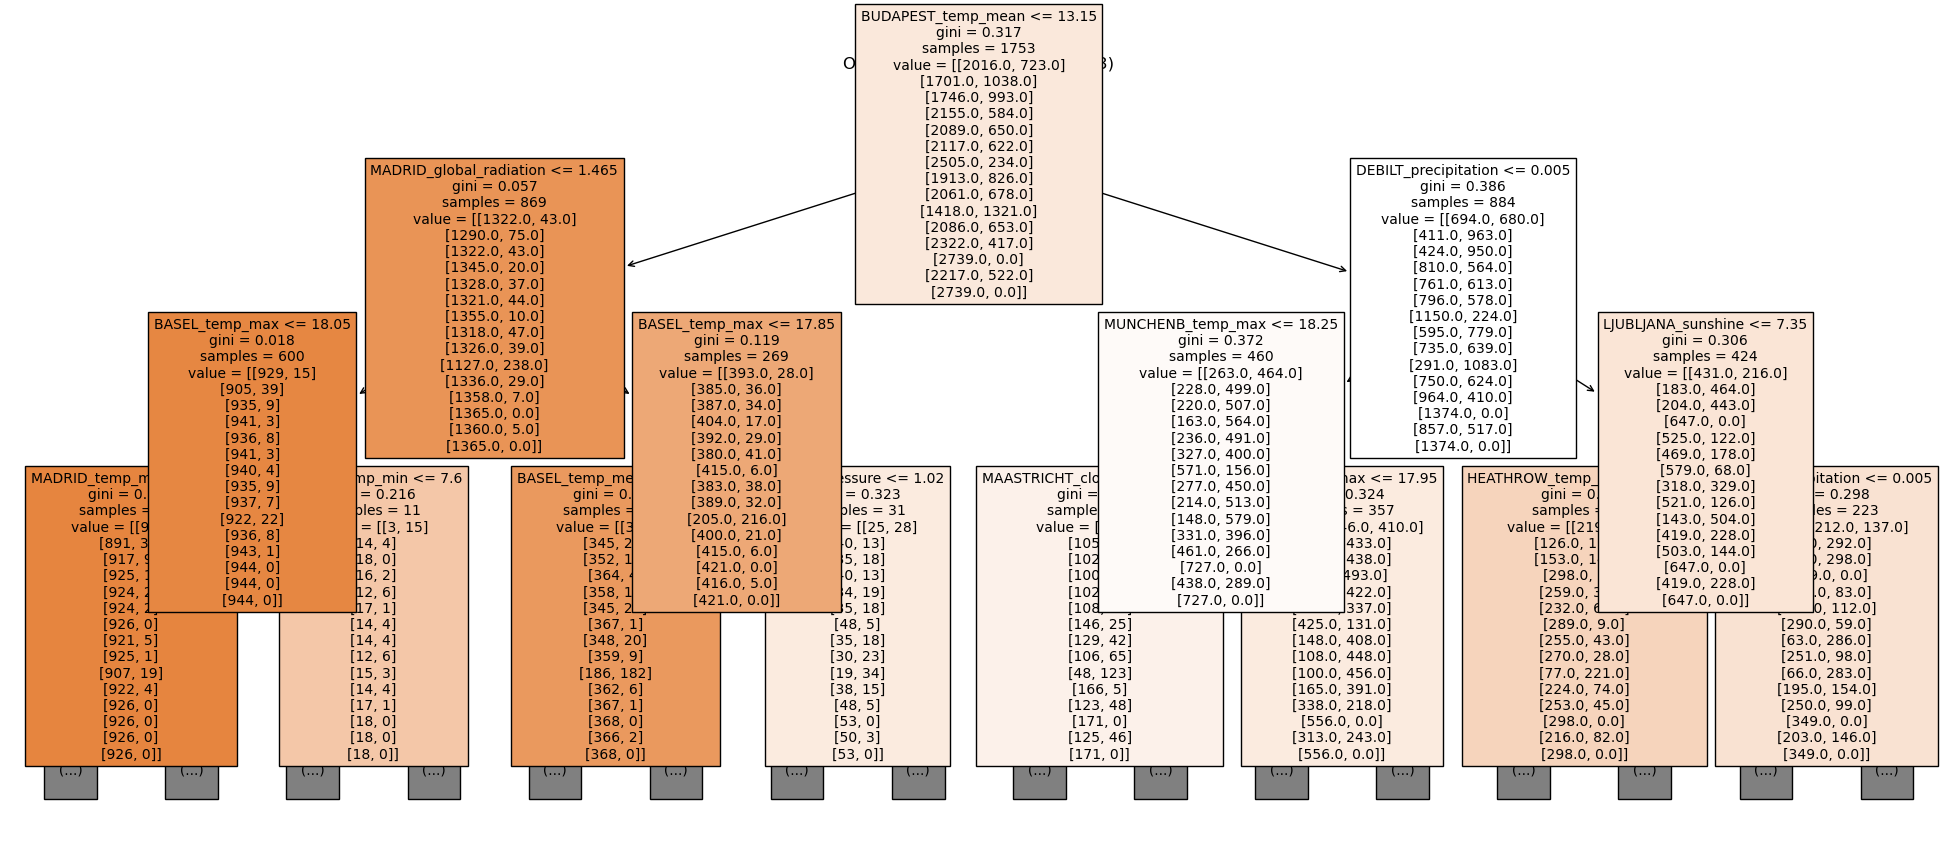

In [26]:
from sklearn.tree import plot_tree

fig = plt.figure(figsize=(25,10))
plot_tree(
    rf_optimized.estimators_[0],       
    feature_names=dfdecade_weather.columns,  
    filled=True,
    max_depth=3,                        # limit depth to keep it readable
    fontsize=10
)
plt.title("Optimized RF: Tree #0 (Depth 3)")
plt.show()

### Feature Importances

In [28]:
importances = rf_optimized.feature_importances_   # 1D array
feature_names = dfdecade_weather.columns.tolist()      

DUSSELDORF_temp_max         0.039894
BASEL_temp_max              0.036076
DEBILT_temp_max             0.031842
MAASTRICHT_temp_max         0.030138
MAASTRICHT_temp_mean        0.028108
LJUBLJANA_temp_max          0.027563
BUDAPEST_temp_max           0.021818
MUNCHENB_temp_max           0.021740
HEATHROW_temp_mean          0.021353
MADRID_temp_max             0.020253
DUSSELDORF_precipitation    0.019722
MUNCHENB_precipitation      0.018152
MAASTRICHT_precipitation    0.018124
BASEL_precipitation         0.018089
LJUBLJANA_temp_mean         0.017793
dtype: float64


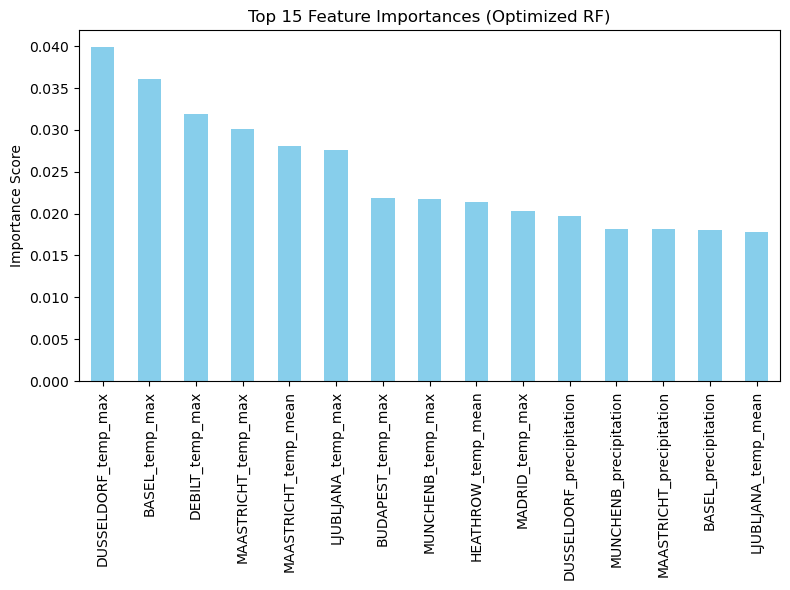

In [29]:
feat_imp_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feat_imp_series.head(15))

# Quick bar plot
plt.figure(figsize=(8,6))
feat_imp_series.head(15).plot(kind='bar', color='skyblue')
plt.title("Top 15 Feature Importances (Optimized RF)")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

### Stations Importance Optimazed

Station-Level Importance (Summed):
 MAASTRICHT    0.106095
DUSSELDORF    0.102463
BASEL         0.098911
LJUBLJANA     0.088792
DEBILT        0.084442
MUNCHENB      0.079395
HEATHROW      0.069470
MADRID        0.065289
STOCKHOLM     0.063742
BUDAPEST      0.061753
BELGRADE      0.057719
OSLO          0.053394
SONNBLICK     0.034396
KASSEL        0.029960
VALENTIA      0.004179
dtype: float64


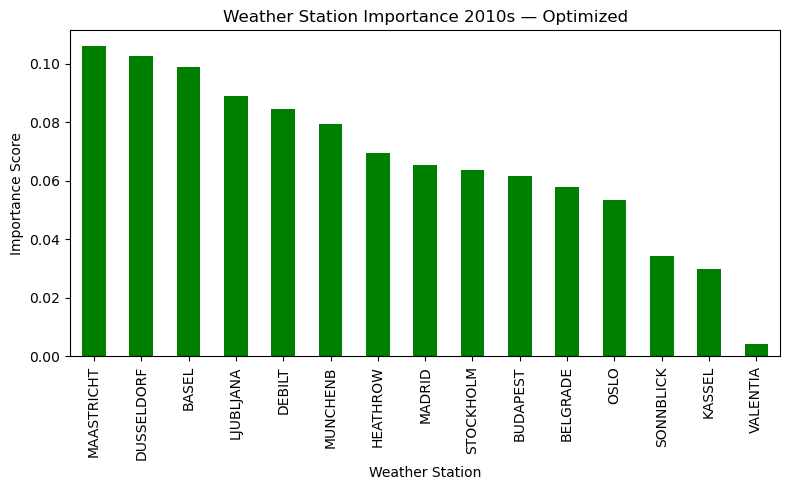

In [31]:
station_importances = {}  # dict to sum up importances station by station

for feat_name, feat_imp in zip(feature_names, importances):
    # Example: 'BASEL_temp_mean' => station 'BASEL'
    station = feat_name.split('_')[0]
    station_importances[station] = station_importances.get(station, 0) + feat_imp

# Convert to a Series for easy plotting
station_import_series = pd.Series(station_importances).sort_values(ascending=False)

print("Station-Level Importance (Summed):\n", station_import_series)

# ----------------------------------------------------------
# 3) Plot the station-level importances
# ----------------------------------------------------------
plt.figure(figsize=(8,5))
station_import_series.plot(kind='bar', color='green')
plt.title("Weather Station Importance 2010s — Optimized")
plt.xlabel("Weather Station")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

---

# Part 1b - Optimizing Hyperparameters - Random Forest for Maastricht (all years) 

In [34]:
weather.head()

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_max,VALENTIA_cloud_cover,VALENTIA_humidity,VALENTIA_pressure,VALENTIA_global_radiation,VALENTIA_precipitation,VALENTIA_sunshine,VALENTIA_temp_mean,VALENTIA_temp_min,VALENTIA_temp_max
0,19600101,1,7,0.85,1.018,0.32,0.09,0.7,6.5,0.8,...,4.9,5,0.88,1.0003,0.45,0.34,4.7,8.5,6.0,10.9
1,19600102,1,6,0.84,1.018,0.36,1.05,1.1,6.1,3.3,...,5.0,7,0.91,1.0007,0.25,0.84,0.7,8.9,5.6,12.1
2,19600103,1,8,0.90,1.018,0.18,0.30,0.0,8.5,5.1,...,4.1,7,0.91,1.0096,0.17,0.08,0.1,10.5,8.1,12.9
3,19600104,1,3,0.92,1.018,0.58,0.00,4.1,6.3,3.8,...,2.3,7,0.86,1.0184,0.13,0.98,0.0,7.4,7.3,10.6
4,19600105,1,6,0.95,1.018,0.65,0.14,5.4,3.0,-0.7,...,4.3,3,0.80,1.0328,0.46,0.00,5.7,5.7,3.0,8.4


In [35]:
weather.shape

(22950, 137)

In [36]:
weather_full = weather
answers_full = answers

## Data Wrangling

In [38]:
# A) Drop the unneeded columns from weather_full
columns_to_drop = weather_full.filter(regex='(_wind_speed|_snow_depth)$').columns
weather_full.drop(columns=columns_to_drop, inplace=True, errors="ignore")

# B) Insert columns for KASSEL_cloud_cover, STOCKHOLM_humidity, etc. 
#    (the same fix made before if those columns are missing.)
#   ...

# Convert date columns to string if you prefer:
weather_full["DATE"] = weather_full["DATE"].astype(str)
answers_full["DATE"] = answers_full["DATE"].astype(str)

print(weather_full.columns)
print(answers_full.columns)

Index(['DATE', 'MONTH', 'BASEL_cloud_cover', 'BASEL_humidity',
       'BASEL_pressure', 'BASEL_global_radiation', 'BASEL_precipitation',
       'BASEL_sunshine', 'BASEL_temp_mean', 'BASEL_temp_min',
       ...
       'STOCKHOLM_temp_max', 'VALENTIA_cloud_cover', 'VALENTIA_humidity',
       'VALENTIA_pressure', 'VALENTIA_global_radiation',
       'VALENTIA_precipitation', 'VALENTIA_sunshine', 'VALENTIA_temp_mean',
       'VALENTIA_temp_min', 'VALENTIA_temp_max'],
      dtype='object', length=137)
Index(['DATE', 'BASEL_pleasant_weather', 'BELGRADE_pleasant_weather',
       'BUDAPEST_pleasant_weather', 'DEBILT_pleasant_weather',
       'DUSSELDORF_pleasant_weather', 'HEATHROW_pleasant_weather',
       'KASSEL_pleasant_weather', 'LJUBLJANA_pleasant_weather',
       'MAASTRICHT_pleasant_weather', 'MADRID_pleasant_weather',
       'MUNCHENB_pleasant_weather', 'OSLO_pleasant_weather',
       'SONNBLICK_pleasant_weather', 'STOCKHOLM_pleasant_weather',
       'VALENTIA_pleasant_weather'],
     

## Filter for One Station (Maastricht)

In [40]:
# 1) For the "X" features:
maastricht_cols = [col for col in weather_full.columns if "MAASTRICHT" in col]
df_maastricht = weather_full[maastricht_cols].copy()
print("df_maastricht shape:", df_maastricht.shape)

# 2) For the "y" target:
answers_maastricht = answers_full["MAASTRICHT_pleasant_weather"].copy()
print("answers_maastricht shape:", answers_maastricht.shape)

drop_candidates = ["DATE","MONTH"]
df_maastricht.drop(columns=drop_candidates, inplace=True, errors="ignore")
print("df_maastricht shape after dropping date/month:", df_maastricht.shape)


df_maastricht shape: (22950, 9)
answers_maastricht shape: (22950,)
df_maastricht shape after dropping date/month: (22950, 9)


## Convert to Arrays & Split

In [42]:
X = df_maastricht.to_numpy()
y = answers_maastricht.to_numpy()

print("X shape:", X.shape)   # e.g. (22950, 9) if 9 columns for Maastricht
print("y shape:", y.shape)   # e.g. (22950,)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)


X shape: (22950, 9)
y shape: (22950,)
Train shapes: (17212, 9) (17212,)
Test shapes: (5738, 9) (5738,)


---

##  Hyperparameter Optimization (GridSearch)

In [45]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'max_features': [1, 2, len(maastricht_cols)],  # or 3
    'min_samples_leaf': [1, 2],
    'min_samples_split': [2, 5],
    'criterion': ['gini', 'entropy']
}

rf_base = RandomForestClassifier(random_state=42)

grid = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    scoring='accuracy',  # single station => normal accuracy
    cv=3,
    n_jobs=-1,
    verbose=2
)
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Best CV Score:", grid.best_score_)

# Refit final model with these best params
best_rf_maastricht = RandomForestClassifier(random_state=42, **grid.best_params_)
best_rf_maastricht.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Params: {'criterion': 'gini', 'max_depth': 5, 'max_features': 9, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best CV Score: 1.0


RandomForestClassifier(max_depth=5, max_features=9, n_estimators=50,
                       random_state=42)

### Evaluate & Plot

Maastricht (entire timeline) - Test Accuracy: 1.0


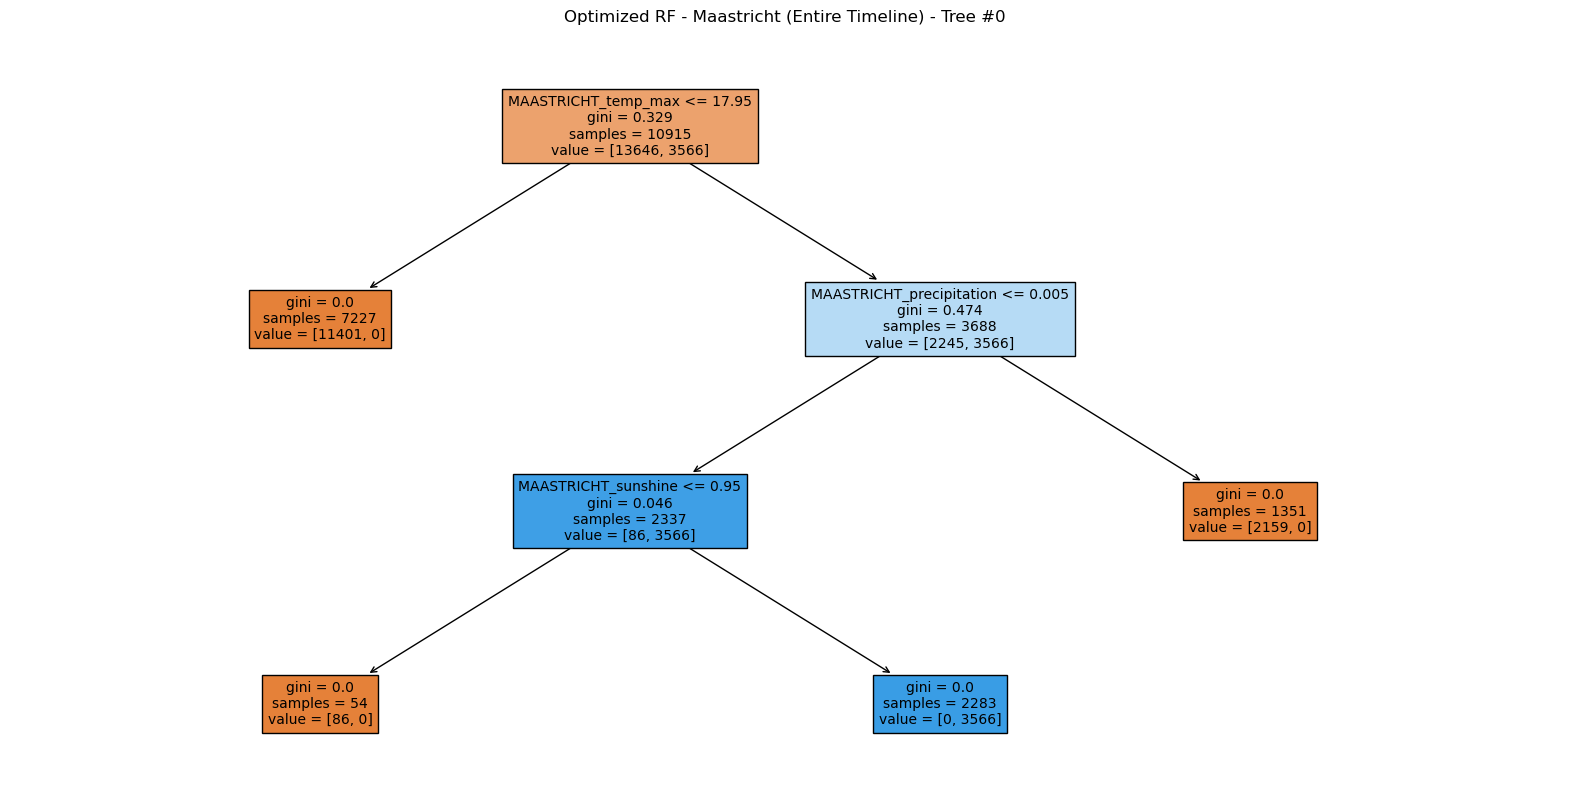

Top features for Maastricht:
 temp_max            0.511365
precipitation       0.457414
sunshine            0.031214
humidity            0.000007
cloud_cover         0.000000
pressure            0.000000
global_radiation    0.000000
temp_mean           0.000000
temp_min            0.000000
dtype: float64


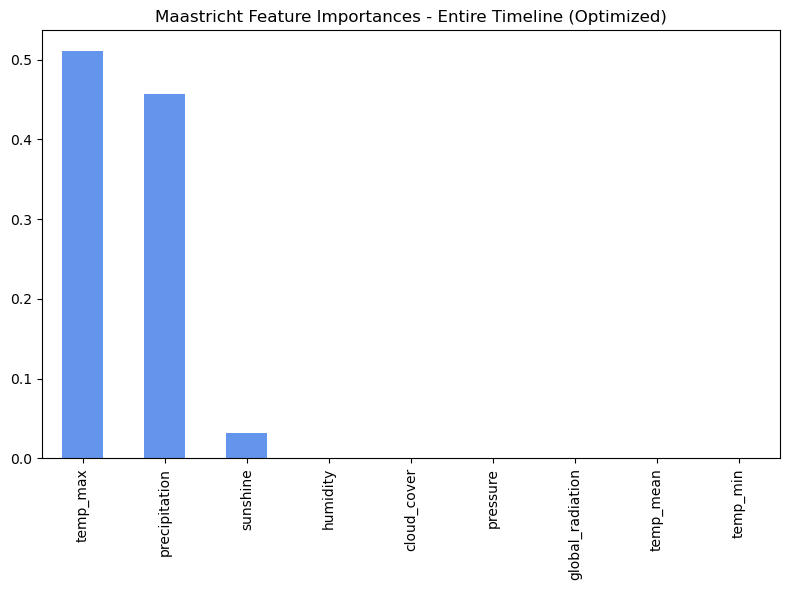

In [47]:
y_pred = best_rf_maastricht.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Maastricht (entire timeline) - Test Accuracy:", acc)

# Plot a tree
fig = plt.figure(figsize=(20,10))
plot_tree(
    best_rf_maastricht.estimators_[0],
    feature_names=df_maastricht.columns,
    filled=True,
    max_depth=3,
    fontsize=10
)
plt.title("Optimized RF - Maastricht (Entire Timeline) - Tree #0")
plt.show()
fig.savefig("Optimized_Maastricht_EntireTimeline_Tree0.png", bbox_inches='tight')

# Feature importances
importances = best_rf_maastricht.feature_importances_
feat_names = [c.replace("MAASTRICHT_","") for c in df_maastricht.columns]

imp_series = pd.Series(importances, index=feat_names).sort_values(ascending=False)
print("Top features for Maastricht:\n", imp_series.head(10))

plt.figure(figsize=(8,6))
imp_series.plot(kind='bar', color='cornflowerblue')
plt.title("Maastricht Feature Importances - Entire Timeline (Optimized)")
plt.tight_layout()
plt.show()

---

# Part 2: Deep Learning CNN — Hyperparameter Optimization

## Reshape the Data for Modeling

In [51]:
# Load your data
# Path to your cleaned dataset
path = r"C:\Users\isaac\Documents\CareerFoundry\3. Machine Learning with Python\Real-World Applications of ML\02 Data"

X = pd.read_csv(os.path.join(path, 'weather_cleaned.csv'))
y = pd.read_csv(os.path.join(path, 'answers_cleaned.csv'))

In [52]:
print(X.shape)  # should be (22950, 135)
print(y.shape)  # should be (22950, 15)

(22950, 135)
(22950, 15)


### Reshape 𝑋

In [55]:
# Convert X and y to NumPy arrays
X = X.values  # or np.array(X)

# Reshape from (22950, 135) --> (22950, 15, 9)
X = X.reshape(-1, 15, 9)

In [57]:
print(X.shape)  # should be (22950, 15, 9)

(22950, 15, 9)


### Reshape y

In [60]:
# Use argmax to transform y

y =  np.argmax(y, axis = 1)

In [62]:
y.shape

(22950,)

### Bayesian Optimization Setup

In [ ]:
!pip install bayesian-optimization

### Data Split

In [78]:
from sklearn.model_selection import train_test_split

# Split data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)  # e.g. (18360, 15, 9), (4590, 15, 9)


(18360, 15, 9) (4590, 15, 9)


### Train on `(X_train, y_train)` evaluate on `(X_test, y_test)`:

In [81]:
model_final.fit(X_train, y_train, epochs=epochs_final, batch_size=batch_final, verbose=2)
test_loss, test_acc = model_final.evaluate(X_test, y_test, verbose=0)
print("Final CNN Test Accuracy:", test_acc)

Epoch 1/16
159/159 - 1s - 7ms/step - accuracy: 0.7296 - loss: 0.7537
Epoch 2/16
159/159 - 1s - 5ms/step - accuracy: 0.7288 - loss: 0.7521
Epoch 3/16
159/159 - 1s - 6ms/step - accuracy: 0.7298 - loss: 0.7472
Epoch 4/16
159/159 - 1s - 7ms/step - accuracy: 0.7216 - loss: 0.7723
Epoch 5/16
159/159 - 1s - 8ms/step - accuracy: 0.7267 - loss: 0.7498
Epoch 6/16
159/159 - 1s - 5ms/step - accuracy: 0.7214 - loss: 0.7528
Epoch 7/16
159/159 - 1s - 8ms/step - accuracy: 0.7236 - loss: 0.7664
Epoch 8/16
159/159 - 1s - 4ms/step - accuracy: 0.7248 - loss: 0.7600
Epoch 9/16
159/159 - 2s - 11ms/step - accuracy: 0.7192 - loss: 0.7685
Epoch 10/16
159/159 - 1s - 8ms/step - accuracy: 0.7301 - loss: 0.7229
Epoch 11/16
159/159 - 1s - 8ms/step - accuracy: 0.7334 - loss: 0.7237
Epoch 12/16
159/159 - 1s - 6ms/step - accuracy: 0.7343 - loss: 0.7134
Epoch 13/16
159/159 - 1s - 6ms/step - accuracy: 0.7300 - loss: 0.7176
Epoch 14/16
159/159 - 1s - 7ms/step - accuracy: 0.7301 - loss: 0.7193
Epoch 15/16
159/159 - 1s - 8

### Define bounds for each hyperparameter:

In [69]:
pbounds = {
    'filters': (16, 128),
    'kernel': (1, 3),
    'dropout': (0.0, 0.5),
    'lr': (1e-3, 1e-1),
    'epochs': (5, 20),
    'batch_size': (32, 256)
}


### Running BayesOpt:

In [72]:
optimizer = BayesianOptimization(
    f=bayes_opt_func,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

optimizer.maximize(init_points=5, n_iter=5)  # do more for a thorough search

print("Best result found:", optimizer.max)

|   iter    |  target   | batch_... |  dropout  |  epochs   |  filters  |  kernel   |    lr     |
-------------------------------------------------------------------------------------------------
| 1         | 0.7666    | 115.9     | 0.4754    | 15.98     | 83.05     | 1.312     | 0.01644   |
| 2         | 0.6479    | 45.01     | 0.4331    | 14.02     | 95.3      | 1.041     | 0.09702   |
| 3         | 0.7451    | 218.5     | 0.1062    | 7.727     | 36.54     | 1.608     | 0.05295   |
| 4         | 0.7432    | 128.8     | 0.1456    | 14.18     | 31.62     | 1.584     | 0.03727   |
| 5         | 0.7644    | 134.2     | 0.3926    | 7.995     | 73.59     | 2.185     | 0.005599  |
| 6         | 0.7339    | 153.0     | 0.3056    | 19.97     | 125.2     | 2.933     | 0.03549   |
| 7         | 0.6479    | 118.0     | 0.4418    | 16.04     | 83.88     | 1.397     | 0.06734   |
| 8         | 0.7459    | 79.12     | 0.4962    | 8.209     | 94.52     | 1.991     | 0.02948   |
| 9         | 0.6443

### Build Final Model (Best Hyperparams)

In [84]:
from sklearn.metrics import confusion_matrix, accuracy_score
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam

filters_final   = 83   # from Bayesian search
kernel_final    = 1
dropout_final   = 0.48
lr_final        = 0.016
epochs_final    = 16
batch_final     = 116

model_final = Sequential()
model_final.add(Conv1D(
    filters=filters_final, kernel_size=kernel_final,
    activation='relu',
    input_shape=(15, 9)
))
model_final.add(MaxPooling1D(pool_size=2))
model_final.add(Flatten())
model_final.add(Dense(32, activation='relu'))

if dropout_final > 0:
    model_final.add(Dropout(dropout_final))

model_final.add(Dense(15, activation='softmax'))

# Compile
opt_final = Adam(learning_rate=lr_final)
model_final.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt_final,
    metrics=['accuracy']
)

### Train

In [86]:
model_final.fit(
    X_train, y_train,
    epochs=epochs_final,
    batch_size=batch_final,
    verbose=2
)

Epoch 1/16
159/159 - 6s - 39ms/step - accuracy: 0.6242 - loss: 1.3039
Epoch 2/16
159/159 - 1s - 8ms/step - accuracy: 0.6443 - loss: 0.9706
Epoch 3/16
159/159 - 1s - 7ms/step - accuracy: 0.6766 - loss: 0.9173
Epoch 4/16
159/159 - 1s - 7ms/step - accuracy: 0.6916 - loss: 0.8812
Epoch 5/16
159/159 - 1s - 5ms/step - accuracy: 0.6976 - loss: 0.8526
Epoch 6/16
159/159 - 1s - 8ms/step - accuracy: 0.7050 - loss: 0.8291
Epoch 7/16
159/159 - 1s - 7ms/step - accuracy: 0.7022 - loss: 0.8424
Epoch 8/16
159/159 - 1s - 8ms/step - accuracy: 0.7019 - loss: 0.8263
Epoch 9/16
159/159 - 2s - 9ms/step - accuracy: 0.7170 - loss: 0.7726
Epoch 10/16
159/159 - 1s - 6ms/step - accuracy: 0.7210 - loss: 0.7616
Epoch 11/16
159/159 - 2s - 12ms/step - accuracy: 0.7240 - loss: 0.7417
Epoch 12/16
159/159 - 1s - 5ms/step - accuracy: 0.7354 - loss: 0.7111
Epoch 13/16
159/159 - 1s - 5ms/step - accuracy: 0.7431 - loss: 0.6882
Epoch 14/16
159/159 - 1s - 9ms/step - accuracy: 0.7504 - loss: 0.6748
Epoch 15/16
159/159 - 1s - 

### Evaluate

In [90]:
test_loss, test_acc = model_final.evaluate(X_test, y_test, verbose=0)
print("\nFinal CNN Test Accuracy:", test_acc)


Final CNN Test Accuracy: 0.8106753826141357


### Confusion Matrix

144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Numeric Confusion Matrix:
 [[2800  138    6    0    0    0    0    0    0   11    0    0    0    0]
 [ 353  519    2    0    0    0    0    0    0    5    0    0    0    0]
 [  47   25   82    5    0    0    0    0    0    3    0    0    0    0]
 [  22    2   19   15    0    3    0    0    0    3    0    0    0    0]
 [  11    0    2    3    0    4    0    0    0    5    0    0    0    0]
 [  18    1    2    0    0   13    0    5    0   28    0    0    0    0]
 [   4    1    1    0    0    1    0    1    0    1    0    0    0    0]
 [  19    2    3    0    0    0    0    4    0   18    0    0    0    0]
 [   4    0    1    0    0    0    0    0    0    2    0    0    0    0]
 [  47   13   10    0    0    1    0    1    0  288    0    0    0    0]
 [   8    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   4    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   3    0    0    0    0    0    0    0    0    0    0

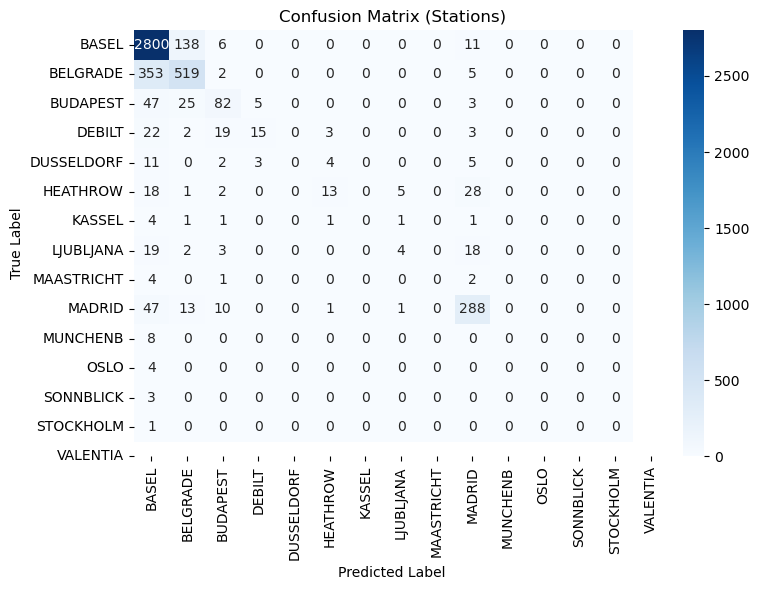

In [99]:
# 1) Map numeric predictions => class indices
y_pred_probas = model_final.predict(X_test)          # shape = (n_test, 15)
y_pred_class  = np.argmax(y_pred_probas, axis=1)     # shape = (n_test,)

cm = confusion_matrix(y_test, y_pred_class)
acc_sklearn = accuracy_score(y_test, y_pred_class)

print("Numeric Confusion Matrix:\n", cm)
print("Test Accuracy Score:", acc_sklearn)

# 3) Show crosstab with station names
stations = {
    0: 'BASEL',
    1: 'BELGRADE',
    2: 'BUDAPEST',
    3: 'DEBILT',
    4: 'DUSSELDORF',
    5: 'HEATHROW',
    6: 'KASSEL',
    7: 'LJUBLJANA',
    8: 'MAASTRICHT',
    9: 'MADRID',
    10: 'MUNCHENB',
    11: 'OSLO',
    12: 'SONNBLICK',
    13: 'STOCKHOLM',
    14: 'VALENTIA'
}


y_true_stations = pd.Series([stations[i] for i in y_test],     name='True')
y_pred_stations = pd.Series([stations[i] for i in y_pred_class], name='Pred')

crosstab = pd.crosstab(y_true_stations, y_pred_stations)
print("\nStation-Level Crosstab:\n", crosstab)

# 4) Heatmap


plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=stations.values(),
            yticklabels=stations.values(),
            cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title("Confusion Matrix (Stations)")
plt.tight_layout()
plt.show()